# Risk Deep Dive: Geographic & Temporal Analysis
   
   Detailed risk analysis for AXA Deutschland bike-share insurance pricing.
   
   **Prerequisites**: Run `make scorecard MODE=nyc` first.
   
   **Audience**: Technical teams, actuaries, data scientists

## How to run (recommended)

From the repo root:

```bash
make all MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
make report MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"
```

The Makefile sets environment variables (e.g. `CITIBIKE_PARQUET_DIR`, `CITIBIKE_YEARS`, `CITIBIKE_MONTHS`) which this notebook reads.


## Analysis Overview
   
   This notebook provides detailed risk analysis including:
   1. **High-Risk Station Identification** - Top 10% riskiest stations
   2. **Geographic Clustering** - Do high-risk stations cluster?
   3. **Risk Distribution** - How is risk distributed across the system?
   4. **Temporal Patterns** - When is exposure highest?
   5. **Executive Summary** - AXA-ready metrics
   
   **Run time**: ~2 minutes

In [1]:
# --- Setup (STRICT + yearly/monthly risk support): locate repo, resolve RUN_DIR, load summaries safely ---

from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Notebook-friendly display
try:
    from IPython.display import display, Markdown
except Exception:
    display = print
    Markdown = lambda x: x

# Ensure figures render in executed notebook
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

plt.ioff()  # nbconvert-friendly

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "Makefile").exists():
            return p
    raise FileNotFoundError(f"Could not find repo root (Makefile) from CWD={Path.cwd().resolve()}")

REPO_ROOT = find_repo_root(Path.cwd())
SUMMARIES_ROOT = REPO_ROOT / "summaries"

def _parse_int_list(val: str | None):
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    parts = re.split(r"[,\s]+", s)
    out = []
    for p in parts:
        if not p:
            continue
        try:
            out.append(int(p))
        except Exception:
            pass
    return out or None

def read_csv_optional(path: Path) -> pd.DataFrame | None:
    return pd.read_csv(path) if path.exists() else None

def read_csv_strict(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing required CSV: {path}")
    return pd.read_csv(path)

# Inputs from Makefile
PARQUET_DIR_ENV = (os.environ.get("CITIBIKE_PARQUET_DIR") or "").strip()
RUN_DIR_ENV     = (os.environ.get("CITIBIKE_RUN_DIR") or "").strip()
MODE_ENV        = (os.environ.get("CITIBIKE_MODE") or os.environ.get("MODE") or "").strip().lower()

YEARS_FILTER  = _parse_int_list(os.environ.get("CITIBIKE_YEARS")  or os.environ.get("YEARS"))
MONTHS_FILTER = _parse_int_list(os.environ.get("CITIBIKE_MONTHS") or os.environ.get("MONTHS"))

PARQUET_DIR = Path(PARQUET_DIR_ENV) if PARQUET_DIR_ENV else Path()
if RUN_DIR_ENV:
    RUN_DIR = Path(RUN_DIR_ENV)
else:
    run_tag = PARQUET_DIR.name if str(PARQUET_DIR).strip() else ""
    RUN_DIR = (SUMMARIES_ROOT / run_tag) if run_tag else Path()

# Resolve relative -> absolute
if str(RUN_DIR).strip() and not RUN_DIR.is_absolute():
    RUN_DIR = (REPO_ROOT / RUN_DIR).resolve()
if str(PARQUET_DIR).strip() and not PARQUET_DIR.is_absolute():
    PARQUET_DIR = (REPO_ROOT / PARQUET_DIR).resolve()

# Strict checks
if not SUMMARIES_ROOT.exists():
    raise FileNotFoundError(f"Expected summaries/ folder at: {SUMMARIES_ROOT}")
if not RUN_DIR.exists():
    raise FileNotFoundError(f"Expected run summaries at: {RUN_DIR}")

print("REPO_ROOT:", REPO_ROOT)
print("RUN_DIR:", RUN_DIR)
print("PARQUET_DIR:", PARQUET_DIR if str(PARQUET_DIR).strip() else "(not set)")
print("MODE (env):", MODE_ENV or "(not set)")
print("YEARS_FILTER:", YEARS_FILTER, "MONTHS_FILTER:", MONTHS_FILTER)

# Figures dir
FIG_DIR = REPO_ROOT / "reports" / RUN_DIR.name / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR)

def savefig(filename: str):
    out = FIG_DIR / filename
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

# Load core per-run summaries (required)
df_year  = read_csv_strict(RUN_DIR / "citibike_trips_by_year.csv")
df_month = read_csv_strict(RUN_DIR / "citibike_trips_by_month.csv")
df_dow   = read_csv_strict(RUN_DIR / "citibike_trips_by_dow.csv")
df_hour  = read_csv_strict(RUN_DIR / "citibike_trips_by_hour.csv")

# Optional outputs
df_station = read_csv_optional(RUN_DIR / "citibike_station_exposure.csv")

# Risk CSVs (overall + new granular variants)
df_risk_overall = read_csv_optional(RUN_DIR / "station_risk_exposure_plus_crashproximity.csv")
df_risk_year    = read_csv_optional(RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year.csv")
df_risk_ym      = read_csv_optional(RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year_month.csv")

# Convenience alias (prefer most granular available)
df_risk = df_risk_ym if df_risk_ym is not None else (df_risk_year if df_risk_year is not None else df_risk_overall)

highlights_path = RUN_DIR / "summary_highlights.md"

# Mode detection
mode = (
    str(df_year["mode"].iloc[0]).lower()
    if ("mode" in df_year.columns and len(df_year))
    else (MODE_ENV or "unknown")
)
print("Detected mode:", mode)

# Apply filters defensively
def _filter_year_month(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if YEARS_FILTER is not None and "year" in out.columns:
        out["year"] = pd.to_numeric(out["year"], errors="coerce")
        out = out[out["year"].isin(YEARS_FILTER)]
    if MONTHS_FILTER is not None and "month" in out.columns:
        out["month"] = pd.to_numeric(out["month"], errors="coerce")
        out = out[out["month"].isin(MONTHS_FILTER)]
    return out

df_year  = _filter_year_month(df_year)
df_month = _filter_year_month(df_month)
df_dow   = _filter_year_month(df_dow)
df_hour  = _filter_year_month(df_hour)

# If df_risk includes year/month, filter it too
if df_risk is not None:
    df_risk = _filter_year_month(df_risk)

run_label = RUN_DIR.name

print("\nRisk files found:")
print(" - overall:", "YES" if df_risk_overall is not None else "NO")
print(" - by_year:", "YES" if df_risk_year is not None else "NO")
print(" - by_year_month:", "YES" if df_risk_ym is not None else "NO")
print("Using df_risk =", "by_year_month" if df_risk is df_risk_ym else ("by_year" if df_risk is df_risk_year else ("overall" if df_risk is df_risk_overall else "None")))


REPO_ROOT: /home/maral/Desktop/citibike-insurance-challenge
RUN_DIR: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2023_m1_2_3_4_5_6_modejc
PARQUET_DIR: /home/maral/Desktop/citibike-insurance-challenge/data/processed/citibike_parquet/y2023_m1_2_3_4_5_6_modejc
MODE (env): jc
YEARS_FILTER: [2023] MONTHS_FILTER: [1, 2, 3, 4, 5, 6]
FIG_DIR: /home/maral/Desktop/citibike-insurance-challenge/reports/y2023_m1_2_3_4_5_6_modejc/figures
Detected mode: jc

Risk files found:
 - overall: YES
 - by_year: YES
 - by_year_month: YES
Using df_risk = None


## 8) Risk Deep Dive Analysis

Now that we have the AXA scorecard, let's analyze:
- **WHERE**: Which stations are highest risk? Do they cluster geographically?
- **WHEN**: Does risk vary by hour of day or day of week?
- **WHO**: What exposure levels do high-risk stations have?

This analysis helps AXA:
1. **Price accurately**: Understand risk distribution
2. **Target prevention**: Find geographic clusters for safety campaigns
3. **Optimize products**: Match offerings to temporal patterns

In [2]:
# ============================================================================
# LOAD SCORECARD (overall) + LOAD RISK (year / year-month if available)
# ============================================================================

import os
import re
from pathlib import Path
import pandas as pd

print("\n" + "="*70)
print("RISK DEEP DIVE ANALYSIS (overall scorecard + yearly/monthly risk)")
print("="*70)

_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        raise ValueError(f"Bad AXA_RADIUS={raw!r}. Use like 450m, 750, 1km, auto.")
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    if meters <= 0:
        raise ValueError(f"AXA_RADIUS must be > 0 (got {raw!r})")
    return int(round(meters))

def available_scorecards(run_dir: Path) -> list[int]:
    radii = []
    for p in run_dir.glob("axa_partner_scorecard_*m.csv"):
        mm = re.match(r"^axa_partner_scorecard_(\d+)m\.csv$", p.name)
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def pick_scorecard_path(run_dir: Path, radius_env: str) -> Path | None:
    avail = available_scorecards(run_dir)
    if not avail:
        return None
    wanted = parse_radius_to_m(radius_env)
    chosen = max(avail) if wanted == -1 else (wanted if wanted in avail else (500 if 500 in avail else max(avail)))
    p = run_dir / f"axa_partner_scorecard_{chosen}m.csv"
    return p if p.exists() else None

radius_env = os.environ.get("AXA_RADIUS", "auto")
scorecard_path = pick_scorecard_path(RUN_DIR, radius_env)

# ---- Load scorecard (overall) ----
if scorecard_path and scorecard_path.exists():
    df_score = pd.read_csv(scorecard_path)
    print(f"✅ Loaded scorecard (overall): {len(df_score):,} stations")
    print(f"   AXA_RADIUS (env): {radius_env} -> using file: {scorecard_path.name}")
else:
    df_score = None
    avail = available_scorecards(RUN_DIR)
    print("❌ Scorecard not found for this run.")
    print(f"   AXA_RADIUS (env): {radius_env}")
    print(f"   Available scorecards in RUN_DIR: {avail}")

if df_score is not None:
    print("\nScorecard columns:", list(df_score.columns))
    if "credibility_flag" in df_score.columns:
        print("\nCredibility breakdown:")
        print(df_score["credibility_flag"].value_counts())
    print("\nSample scorecard rows:")
    display(df_score.head(5))

# ---- Load year/month risk tables (these are the ones that should have year/month) ----
risk_overall_path = RUN_DIR / "station_risk_exposure_plus_crashproximity.csv"
risk_year_path    = RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year.csv"
risk_ym_path      = RUN_DIR / "station_risk_exposure_plus_crashproximity_by_year_month.csv"

df_risk_overall = pd.read_csv(risk_overall_path) if risk_overall_path.exists() else None
df_risk_year    = pd.read_csv(risk_year_path) if risk_year_path.exists() else None
df_risk_ym      = pd.read_csv(risk_ym_path) if risk_ym_path.exists() else None

# Prefer most granular
df_risk = df_risk_ym if df_risk_ym is not None else (df_risk_year if df_risk_year is not None else df_risk_overall)

print("\nRisk table availability:")
print(" - overall:", "YES" if df_risk_overall is not None else "NO")
print(" - by_year:", "YES" if df_risk_year is not None else "NO")
print(" - by_year_month:", "YES" if df_risk_ym is not None else "NO")

if df_risk is None:
    print("⚠️ No risk table found; yearly/monthly analysis cannot run.")
else:
    print("✅ Using df_risk =", "by_year_month" if df_risk is df_risk_ym else ("by_year" if df_risk is df_risk_year else "overall"))
    print("df_risk columns:", list(df_risk.columns))

    # Quick sanity: do we have year/month?
    has_year = "year" in df_risk.columns
    has_month = "month" in df_risk.columns
    print(f"Has year? {has_year} | Has month? {has_month}")

    # Show a few rows (sorted so you can see multiple years if present)
    show_cols = [c for c in ["mode","year","month","station_id","station_name","trips"] if c in df_risk.columns]
    if show_cols:
        display(df_risk.sort_values([c for c in ["year","month"] if c in df_risk.columns] + ["trips"] if "trips" in df_risk.columns else []).head(10))
    else:
        display(df_risk.head(10))



RISK DEEP DIVE ANALYSIS (overall scorecard + yearly/monthly risk)
✅ Loaded scorecard (overall): 83 stations
   AXA_RADIUS (env): 500m -> using file: axa_partner_scorecard_500m.csv

Scorecard columns: ['mode', 'start_station_id', 'start_station_name', 'station_lat', 'station_lng', 'exposure_trips', 'crash_count', 'risk_rate_per_100k_trips', 'risk_rate_ci_low', 'risk_rate_ci_high', 'risk_proxy_available', 'credibility_flag', 'exposure_pct', 'risk_pct', 'axa_priority_score', 'prevention_hotspot', 'product_hotspot', 'acquisition_hotspot', 'exposure_index_pct', 'eb_risk_rate_per_100k_trips', 'risk_index_pct', 'expected_incidents_proxy', 'scoring_strategy']

Credibility breakdown:
credibility_flag
no_risk_data    83
Name: count, dtype: int64

Sample scorecard rows:


,mode,start_station_id,start_station_name,station_lat,station_lng,exposure_trips,crash_count,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,...,risk_pct,axa_priority_score,prevention_hotspot,product_hotspot,acquisition_hotspot,exposure_index_pct,eb_risk_rate_per_100k_trips,risk_index_pct,expected_incidents_proxy,scoring_strategy
0,jc,JC115,Grove St PATH,40.719390,-74.043106,46200,0,0.0,0.0,7.984588,...,0.0,1.000000,True,True,True,100.000000,NaN,NaN,NaN,exposure_only_no_risk_signal
1,jc,HB102,Hoboken Terminal - River St & Hudson Pl,40.736078,-74.029131,40079,0,0.0,0.0,9.204021,...,0.0,0.987952,True,True,True,98.795181,NaN,NaN,NaN,exposure_only_no_risk_signal
2,jc,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,40.737003,-74.027777,30863,0,0.0,0.0,11.952433,...,0.0,0.975904,True,True,True,97.590361,NaN,NaN,NaN,exposure_only_no_risk_signal
3,jc,HB101,Hoboken Terminal - Hudson St & Hudson Pl,40.735935,-74.030318,24906,0,0.0,0.0,14.811208,...,0.0,0.963855,True,True,True,96.385542,NaN,NaN,NaN,exposure_only_no_risk_signal
4,jc,HB105,City Hall - Washington St & 1 St,40.737338,-74.030987,22418,0,0.0,0.0,16.454989,...,0.0,0.951807,True,True,True,95.180723,NaN,NaN,NaN,exposure_only_no_risk_signal



Risk table availability:
 - overall: YES
 - by_year: YES
 - by_year_month: YES
✅ Using df_risk = by_year_month
df_risk columns: ['mode', 'start_station_id', 'start_station_name', 'year', 'month', 'trips', 'start_trips', 'end_trips', 'touchpoints', 'station_lat', 'station_lng', 'crashes_within_500m', 'crashes_within_500m_per_100k_trips', 'risk_proxy_available', 'data_quality']
Has year? True | Has month? True


,mode,start_station_id,start_station_name,year,month,trips,start_trips,end_trips,touchpoints,station_lat,station_lng,crashes_within_500m,crashes_within_500m_per_100k_trips,risk_proxy_available,data_quality
462,jc,JC108,Bergen Ave & Stegman St,2023,1,98,52,46,98,40.706623,-74.086694,0,0.0,0,year_month
456,jc,JC107,Grant Ave & MLK Dr,2023,1,127,59,68,127,40.709179,-74.080810,0,0.0,0,year_month
317,jc,JC063,Jackson Square,2023,1,159,81,78,159,40.711140,-74.078898,0,0.0,0,year_month
281,jc,JC051,Union St,2023,1,254,126,128,254,40.718191,-74.083590,0,0.0,0,year_month
413,jc,JC097,York St & Marin Blvd,2023,1,286,107,179,286,40.716616,-74.042406,0,0.0,0,year_month
293,jc,JC053,Lincoln Park,2023,1,364,182,182,364,40.724610,-74.078419,0,0.0,0,year_month
215,jc,JC018,5 Corners Library,2023,1,420,225,195,420,40.734975,-74.059523,0,0.0,0,year_month
311,jc,JC059,Heights Elevator,2023,1,446,244,202,446,40.748726,-74.040457,0,0.0,0,year_month
323,jc,JC065,Dey St,2023,1,453,208,245,453,40.737718,-74.066941,0,0.0,0,year_month
389,jc,JC084,Communipaw & Berry Lane,2023,1,472,223,249,472,40.714368,-74.066627,0,0.0,0,year_month


### 8.1 High-Risk Stations: WHO and WHERE

In [3]:
# --- HIGH-RISK STATIONS ---
if df_score is not None:
    print("\n" + "="*70)
    print("HIGH-RISK STATIONS ANALYSIS")
    print("="*70)
    
    # Filter to credible high-risk stations (top 10% risk)
    credible_stations = df_score[df_score['credibility_flag'] == 'credible'].copy()
    
    if len(credible_stations) > 0 and 'risk_index_pct' in credible_stations.columns:
        high_risk = credible_stations[credible_stations['risk_index_pct'] >= 90].copy()
        
        print(f"\nHigh-risk stations (≥90th percentile): {len(high_risk):,}")
        print(f"Total exposure at high-risk stations: {high_risk['exposure_trips'].sum():,} trips")
        
        # Top 10 highest risk
        top_risk = high_risk.nlargest(10, 'eb_risk_rate_per_100k_trips')[[
            'start_station_id', 'start_station_name', 'station_lat', 'station_lng',
            'exposure_trips', 'crash_count', 'eb_risk_rate_per_100k_trips', 'risk_index_pct'
        ]].copy()
        
        print("\n📍 Top 10 Highest-Risk Stations:")
        display(top_risk)

        # ------------------------------------------------------------
        # PLOT: Top 10 Highest-Risk Stations
        # ------------------------------------------------------------
        try:
            import matplotlib.pyplot as plt
            import numpy as np

            # Sort for nicer bar order (lowest at bottom, highest at top)
            top_plot = top_risk.sort_values('eb_risk_rate_per_100k_trips', ascending=True).copy()

            fig, ax = plt.subplots(figsize=(11, 6))

            y = np.arange(len(top_plot))
            ax.barh(y, top_plot['eb_risk_rate_per_100k_trips'], edgecolor='black')

            ax.set_yticks(y)
            ax.set_yticklabels([str(n)[:40] for n in top_plot['start_station_name']], fontsize=9)
            ax.set_xlabel('E-bike Risk Rate per 100k Trips', fontsize=11)
            ax.set_title('Top 10 Highest-Risk Stations (Credible, ≥90th Percentile)', fontsize=12, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)

            plt.tight_layout()
            savefig("top10_highest_risk_stations.png")
            plt.show()

            print("✓ Saved plot: top10_highest_risk_stations.png")

        except Exception as e:
            print(f" Could not generate plot: {e}")

        # Geographic clustering analysis
        if len(high_risk) > 1:
            try:
                from sklearn.cluster import DBSCAN
                import numpy as np
                
                # Cluster high-risk stations geographically
                coords = high_risk[['station_lat', 'station_lng']].values
                
                # DBSCAN clustering (0.01 degrees ≈ 1km)
                clustering = DBSCAN(eps=0.01, min_samples=2).fit(coords)
                high_risk['cluster'] = clustering.labels_
                
                # Count clusters
                n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
                n_noise = list(clustering.labels_).count(-1)
                
                print(f"\n🗺️  Geographic Clustering:")
                print(f"  High-risk clusters identified: {n_clusters}")
                print(f"  Isolated high-risk stations: {n_noise}")
                
                # Show cluster details
                if n_clusters > 0:
                    cluster_summary = high_risk[high_risk['cluster'] >= 0].groupby('cluster').agg({
                        'start_station_id': 'count',
                        'exposure_trips': 'sum',
                        'crash_count': 'sum',
                        'station_lat': 'mean',
                        'station_lng': 'mean'
                    }).rename(columns={'start_station_id': 'stations_in_cluster'})
                    
                    print("\nCluster Details:")
                    display(cluster_summary)
            except ImportError:
                print("⚠️  sklearn not installed - skipping geographic clustering")
                print("   Install with: pip install scikit-learn")
    else:
        print("⚠️  No credible stations with risk data available")
else:
    print("⚠️  df_score is None (no scoring data available)")



HIGH-RISK STATIONS ANALYSIS
⚠️  No credible stations with risk data available


### 8.2 Risk Distribution Overview

In [4]:
# --- RISK DISTRIBUTION ---
if df_score is not None and len(credible_stations) > 0:
    print("\n" + "="*70)
    print("RISK DISTRIBUTION ANALYSIS")
    print("="*70)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Risk Histogram
    ax = axes[0, 0]
    ax.hist(credible_stations['eb_risk_rate_per_100k_trips'].dropna(), 
            bins=30, edgecolor='black', alpha=0.7, color='#2E86AB')
    ax.axvline(credible_stations['eb_risk_rate_per_100k_trips'].median(), 
               color='red', linestyle='--', label='Median', linewidth=2)
    ax.set_xlabel('EB Risk Rate (per 100k trips)', fontsize=11)
    ax.set_ylabel('Number of Stations', fontsize=11)
    ax.set_title('Risk Distribution (Credible Stations Only)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 2. Exposure vs Risk Scatter
    ax = axes[0, 1]
    scatter = ax.scatter(
        credible_stations['exposure_trips'], 
        credible_stations['eb_risk_rate_per_100k_trips'],
        c=credible_stations['crash_count'],
        cmap='YlOrRd',
        alpha=0.6,
        s=50
    )
    ax.set_xlabel('Exposure (trips)', fontsize=11)
    ax.set_ylabel('EB Risk Rate (per 100k trips)', fontsize=11)
    ax.set_title('Risk vs Exposure', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    plt.colorbar(scatter, ax=ax, label='Crash Count')
    ax.grid(alpha=0.3)
    
    # Mark prevention hotspots
    if 'prevention_hotspot' in credible_stations.columns:
        hotspots = credible_stations[credible_stations['prevention_hotspot'] == True]
        if len(hotspots) > 0:
            ax.scatter(hotspots['exposure_trips'], 
                      hotspots['eb_risk_rate_per_100k_trips'],
                      color='red', s=200, marker='*', 
                      edgecolors='black', linewidths=1,
                      label='Prevention Hotspots', zorder=5)
            ax.legend()
    
    # 3. Risk Tiers
    ax = axes[1, 0]
    if 'risk_index_pct' in credible_stations.columns:
        # Create risk tiers
        credible_stations['risk_tier'] = pd.cut(
            credible_stations['risk_index_pct'],
            bins=[0, 33, 66, 100],
            labels=['Low Risk', 'Medium Risk', 'High Risk']
        )
        
        tier_counts = credible_stations['risk_tier'].value_counts()
        colors = ['#4CAF50', '#FFC107', '#F44336']
        tier_counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
        ax.set_xlabel('Risk Tier', fontsize=11)
        ax.set_ylabel('Number of Stations', fontsize=11)
        ax.set_title('Station Distribution by Risk Tier', fontsize=12, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.grid(alpha=0.3, axis='y')
        
        # Add percentages on bars
        for i, v in enumerate(tier_counts):
            pct = v / len(credible_stations) * 100
            ax.text(i, v, f'{v}\n({pct:.1f}%)', 
                   ha='center', va='bottom', fontweight='bold')
    
    # 4. Expected Incidents Distribution
    ax = axes[1, 1]
    if 'expected_incidents_proxy' in credible_stations.columns:
        top_20 = credible_stations.nlargest(20, 'expected_incidents_proxy')
        ax.barh(range(len(top_20)), top_20['expected_incidents_proxy'], 
                color='#E74C3C', edgecolor='black')
        ax.set_yticks(range(len(top_20)))
        ax.set_yticklabels([f"{row['start_station_name'][:30]}..." 
                           if len(row['start_station_name']) > 30 
                           else row['start_station_name']
                           for _, row in top_20.iterrows()], fontsize=8)
        ax.set_xlabel('Expected Incidents Proxy', fontsize=11)
        ax.set_title('Top 20 Stations by Expected Impact', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    savefig("08_risk_distribution_analysis.png")
    plt.show()

### 8.3 Temporal Risk Patterns: WHEN does risk peak?


TEMPORAL PATTERNS: HOUR OF DAY


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2023_m1_2_3_4_5_6_modejc/figures/09_trips_by_hour.png


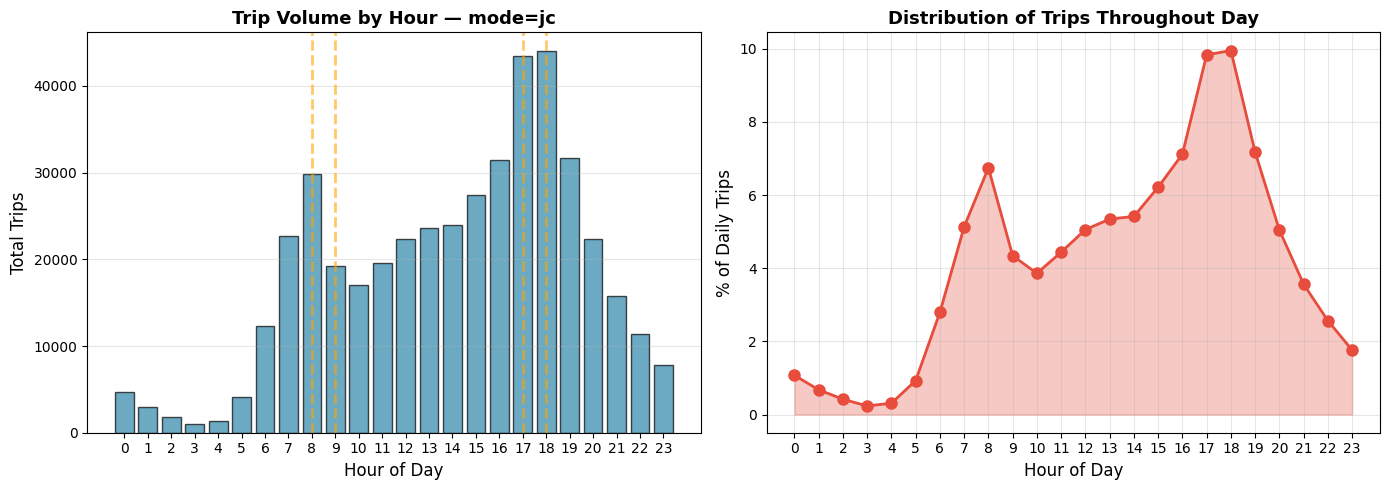


📊 Hour-of-Day Analysis:

Top 5 Busiest Hours:


,hour,trips,pct_of_daily
18,18,43975,9.951054
17,17,43459,9.834289
19,19,31707,7.174942
16,16,31455,7.117917
8,8,29810,6.745672


In [5]:
# --- TEMPORAL PATTERNS: HOUR OF DAY ---
if df_hour is not None:
    print("\n" + "="*70)
    print("TEMPORAL PATTERNS: HOUR OF DAY")
    print("="*70)
    
    # Hour data is already aggregated system-wide
    hour_summary = df_hour.groupby('hour')['trips'].sum().reset_index()
    hour_summary = hour_summary.sort_values('hour')
    
    # Calculate percentage of daily trips
    total_trips = hour_summary['trips'].sum()
    hour_summary['pct_of_daily'] = (hour_summary['trips'] / total_trips) * 100
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Trip volume by hour
    ax1.bar(hour_summary['hour'], hour_summary['trips'], 
           color='#2E86AB', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Hour of Day', fontsize=12)
    ax1.set_ylabel('Total Trips', fontsize=12)
    ax1.set_title(f'Trip Volume by Hour — mode={mode}', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(0, 24))
    ax1.grid(alpha=0.3, axis='y')
    
    # Mark rush hours
    rush_hours = [8, 9, 17, 18]
    for rh in rush_hours:
        ax1.axvline(rh, color='orange', linestyle='--', alpha=0.6, linewidth=2)
    
    # 2. Percentage distribution
    ax2.plot(hour_summary['hour'], hour_summary['pct_of_daily'], 
            marker='o', linewidth=2, markersize=8, color='#E74C3C')
    ax2.fill_between(hour_summary['hour'], hour_summary['pct_of_daily'], 
                     alpha=0.3, color='#E74C3C')
    ax2.set_xlabel('Hour of Day', fontsize=12)
    ax2.set_ylabel('% of Daily Trips', fontsize=12)
    ax2.set_title('Distribution of Trips Throughout Day', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(0, 24))
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    savefig("09_trips_by_hour.png")
    plt.show()
    
    print("\n📊 Hour-of-Day Analysis:")
    top_hours = hour_summary.nlargest(5, 'trips')[['hour', 'trips', 'pct_of_daily']]
    print("\nTop 5 Busiest Hours:")
    display(top_hours)


TEMPORAL PATTERNS: DAY OF WEEK


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2023_m1_2_3_4_5_6_modejc/figures/10_trips_by_day_of_week.png


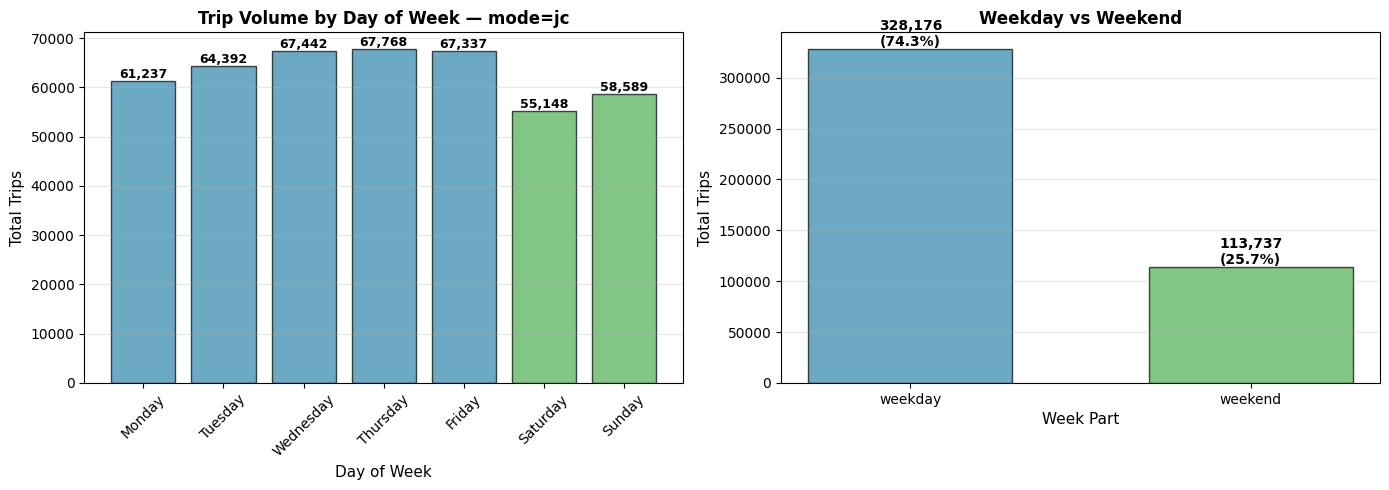


📊 Day-of-Week Analysis:


,dow_name,trips,pct_of_weekly
0,Monday,61237,13.857252
1,Tuesday,64392,14.571194
2,Wednesday,67442,15.261375
3,Thursday,67768,15.335145
4,Friday,67337,15.237615
5,Saturday,55148,12.479379
6,Sunday,58589,13.258039


In [6]:
# --- TEMPORAL PATTERNS: DAY OF WEEK (robust) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if df_dow is None:
    print("df_dow is None; skipping DOW section.")
else:
    print("\n" + "="*70)
    print("TEMPORAL PATTERNS: DAY OF WEEK")
    print("="*70)

    d = df_dow.copy()

    if "dow" not in d.columns or "trips" not in d.columns:
        raise KeyError(f"df_dow missing required columns. Have: {list(d.columns)}")

    d["dow"] = pd.to_numeric(d["dow"], errors="coerce")
    d["trips"] = pd.to_numeric(d["trips"], errors="coerce").fillna(0).astype(int)
    d = d.dropna(subset=["dow"]).copy()
    d["dow"] = d["dow"].astype(int)

    if "dow_name" not in d.columns:
        dow_map = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
        d["dow_name"] = d["dow"].map(dow_map).fillna(d["dow"].astype(str))

    if "week_part" not in d.columns:
        d["week_part"] = np.where(d["dow"] >= 5, "weekend", "weekday")

    dow_summary = (
        d.groupby(["dow", "dow_name"], as_index=False)["trips"]
         .sum()
         .sort_values("dow")
    )

    total_trips = dow_summary["trips"].sum()
    dow_summary["pct_of_weekly"] = (dow_summary["trips"] / total_trips) * 100 if total_trips > 0 else 0.0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    colors = ["#4CAF50" if x in ("Saturday","Sunday") else "#2E86AB" for x in dow_summary["dow_name"]]
    ax1.bar(dow_summary["dow_name"], dow_summary["trips"], color=colors, edgecolor="black", alpha=0.7)
    ax1.set_xlabel("Day of Week", fontsize=11)
    ax1.set_ylabel("Total Trips", fontsize=11)
    ax1.set_title(f"Trip Volume by Day of Week — mode={mode}", fontsize=12, fontweight="bold")
    ax1.tick_params(axis="x", rotation=45)
    ax1.grid(alpha=0.3, axis="y")

    for i, row in dow_summary.reset_index(drop=True).iterrows():
        ax1.text(i, row["trips"], f"{row['trips']:,.0f}",
                 ha="center", va="bottom", fontweight="bold", fontsize=9)

    wp = d.groupby("week_part", as_index=False)["trips"].sum()
    wp["pct"] = (wp["trips"] / wp["trips"].sum()) * 100 if wp["trips"].sum() > 0 else 0.0
    colors_wp = ["#2E86AB" if x == "weekday" else "#4CAF50" for x in wp["week_part"]]
    ax2.bar(wp["week_part"], wp["trips"], color=colors_wp, edgecolor="black", width=0.6, alpha=0.7)
    ax2.set_xlabel("Week Part", fontsize=11)
    ax2.set_ylabel("Total Trips", fontsize=11)
    ax2.set_title("Weekday vs Weekend", fontsize=12, fontweight="bold")
    ax2.grid(alpha=0.3, axis="y")

    for i, row in wp.reset_index(drop=True).iterrows():
        ax2.text(i, row["trips"], f"{row['trips']:,.0f}\n({row['pct']:.1f}%)",
                 ha="center", va="bottom", fontweight="bold", fontsize=10)

    plt.tight_layout()
    savefig("10_trips_by_day_of_week.png")
    plt.show()

    print("\n📊 Day-of-Week Analysis:")
    display(dow_summary[["dow_name", "trips", "pct_of_weekly"]])


### 8.4 Executive Risk Summary for AXA

In [7]:
# --- EXECUTIVE RISK SUMMARY ---
if df_score is not None:
    print("\n" + "="*70)
    print("EXECUTIVE RISK SUMMARY FOR AXA")
    print("="*70)
    
    # Create summary metrics
    summary_data = []
    
    # Overall metrics
    total_stations = len(df_score)
    credible_count = len(df_score[df_score['credibility_flag'] == 'credible'])
    
    summary_data.append({
        'Metric': 'Total Stations',
        'Value': f"{total_stations:,}",
        'Notes': f"{mode.upper()} mode"
    })
    
    summary_data.append({
        'Metric': 'Credible Stations (≥5K trips)',
        'Value': f"{credible_count:,} ({credible_count/total_stations*100:.1f}%)",
        'Notes': 'Suitable for risk-based pricing'
    })
    
    # Risk tiers
    if 'risk_tier' in credible_stations.columns:
        high_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'High Risk'])
        medium_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'Medium Risk'])
        low_risk_count = len(credible_stations[credible_stations['risk_tier'] == 'Low Risk'])
        
        summary_data.append({
            'Metric': 'High Risk Stations',
            'Value': f"{high_risk_count:,} ({high_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Premium pricing tier'
        })
        
        summary_data.append({
            'Metric': 'Medium Risk Stations',
            'Value': f"{medium_risk_count:,} ({medium_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Standard pricing tier'
        })
        
        summary_data.append({
            'Metric': 'Low Risk Stations',
            'Value': f"{low_risk_count:,} ({low_risk_count/credible_count*100:.1f}%)",
            'Notes': 'Discount pricing tier'
        })
    
    # Hotspots
    if 'prevention_hotspot' in df_score.columns:
        prevention_count = df_score['prevention_hotspot'].sum()
        summary_data.append({
            'Metric': 'Prevention Hotspots',
            'Value': f"{int(prevention_count):,}",
            'Notes': 'High exposure + High risk → Safety campaigns'
        })
    
    if 'product_hotspot' in df_score.columns:
        product_count = df_score['product_hotspot'].sum()
        summary_data.append({
            'Metric': 'Product Hotspots',
            'Value': f"{int(product_count):,}",
            'Notes': 'High exposure → Insurance sales opportunity'
        })
    
    if 'acquisition_hotspot' in df_score.columns:
        acquisition_count = df_score['acquisition_hotspot'].sum()
        summary_data.append({
            'Metric': 'Acquisition Hotspots',
            'Value': f"{int(acquisition_count):,}",
            'Notes': 'High exposure + Low risk → Easy wins'
        })
    
    # Display summary table
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)
    
    # Save to CSV
    summary_csv = RUN_DIR / "risk_executive_summary.csv"
    df_summary.to_csv(summary_csv, index=False)
    print(f"\n✅ Saved executive summary to: {summary_csv}")


EXECUTIVE RISK SUMMARY FOR AXA


,Metric,Value,Notes
0,Total Stations,83,JC mode
1,Credible Stations (≥5K trips),0 (0.0%),Suitable for risk-based pricing
2,Prevention Hotspots,9,High exposure + High risk → Safety campaigns
3,Product Hotspots,17,High exposure → Insurance sales opportunity
4,Acquisition Hotspots,25,High exposure + Low risk → Easy wins



✅ Saved executive summary to: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2023_m1_2_3_4_5_6_modejc/risk_executive_summary.csv
